# Example: mesh Fraser Hillslope, CO

Here we mesh the [Coweeta Hydrologic Laboratory](https://www.srs.fs.usda.gov/coweeta/) as an example of how to pull data in from default locations and generate a fully functional ATS mesh.

This might be the worst example to use to learn how to use Watershed Workflows.  But it is useful to demonstrate the breadth of problems this project was intended to solve.

This includes a range of datasets:

* National Hydrography Dataset (NHD) Plus for river network
* National Resources Conservation Service (NRCS) Soil Survey data for soil types
* National Land Cover Database (NLCD) for land cover/transpiration/rooting depths
* National Elevation Dataset (NED) for elevation/DEM

Watershed Workflow version: <branch: [mesh-custom-shape](https://github.com/pinshuai/watershed-workflow/tree/mesh-custom-shape), tag: >

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
# %matplotlib notebook

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [54]:
import os,sys
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as pcm
import shapely
import logging
import fiona
import rasterio
import scipy
import scipy.ndimage

In [4]:
import sys
sys.path.append("./")
# sys.path.append("/Users/shua784/Dropbox/github/watershed-workflow")
# sys.path.append("/Users/shua784/Dropbox/github/watershed-workflow/workflow_tpls")
# sys.path.append("/Users/shua784/Dropbox/github/watershed-workflow/workflow")
sys.path.append("/Users/shua784/Dropbox/github/seacas/install/lib")

sys.path.append("../../watershed-workflow")
sys.path.append("../workflow_tpls")
sys.path.append("../workflow")

In [5]:
import workflow
import workflow.source_list
import workflow.ui
import workflow.colors
import workflow.condition
import workflow.mesh
import workflow.split_hucs

workflow.ui.setup_logging(1,None)

In [49]:
watershed_name = "SecondGrowth"
meshRes = "10m"
fname_surface_mesh = f"./meshes/{watershed_name}_surface_mesh.vtk"
fname_final_mesh = f"./meshes/{watershed_name}_mesh-{meshRes}.exo"

In [37]:
data_dir = "/Users/shua784/OneDrive - PNNL/Projects/Fraser_hillslope/data/"
bnd_shp = data_dir + "GIS/shapefiles/SecondGrowth/SecondGrowth_UTM.shp"
river_shp = data_dir + "GIS/shapefiles/SecondGrowth_trench/trench_line_UTM.shp"

fname_dem = data_dir + "GIS/DEM/SecondGrowth.tif"

## Import watershed boundary

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

In [17]:
# specify the input shapefile and a hint as to what HUC it is in.
logging.info("")
logging.info("Meshing shape: {}".format(bnd_shp))
logging.info("="*30)

# get the shape and crs of the shape
crs, watershed = workflow.get_split_form_shapes(bnd_shp)

2021-10-18 22:36:15,532 - root - INFO: 
2021-10-18 22:36:15,533 - root - INFO: Meshing shape: /Users/shua784/OneDrive - PNNL/Projects/Fraser_hillslope/data/GIS/shapefiles/SecondGrowth/SecondGrowth_UTM.shp
2021-10-18 22:36:15,533 - root - INFO: ==============================
2021-10-18 22:36:15,534 - root - INFO: 
2021-10-18 22:36:15,534 - root - INFO: Loading shapes
2021-10-18 22:36:15,535 - root - INFO: ------------------------------
2021-10-18 22:36:15,535 - root - INFO: Loading file: '/Users/shua784/OneDrive - PNNL/Projects/Fraser_hillslope/data/GIS/shapefiles/SecondGrowth/SecondGrowth_UTM.shp'
2021-10-18 22:36:15,554 - root - INFO: ... found 1 shapes
2021-10-18 22:36:15,554 - root - INFO: Converting to shapely


In [18]:
crs

<Projected CRS: EPSG:32613>
Name: WGS 84 / UTM zone 13N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 108°W and 102°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Northwest Territories (NWT); Nunavut; Saskatchewan. Mexico. United States (USA).
- bounds: (-108.0, 0.0, -102.0, 84.0)
Coordinate Operation:
- name: UTM zone 13N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

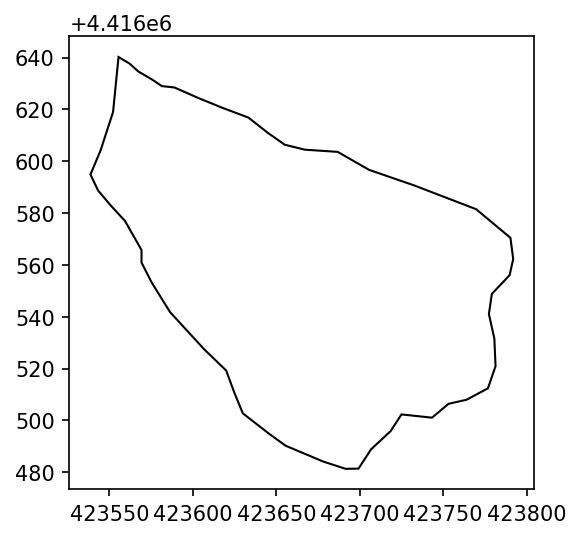

In [19]:
fig,ax = plt.subplots(1,1, figsize=(4,4))
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)

A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [8]:
# set up a dictionary of source objects
sources = workflow.source_list.get_default_sources()
# sources['HUC'] = workflow.source_list.huc_sources['NHD Plus']
# sources['hydrography'] = workflow.source_list.hydrography_sources['NHD Plus']
workflow.source_list.log_sources(sources)

2021-10-18 22:25:29,697 - root - INFO: Using sources:
2021-10-18 22:25:29,698 - root - INFO: --------------
2021-10-18 22:25:29,698 - root - INFO: HUC: National Watershed Boundary Dataset (WBD)
2021-10-18 22:25:29,699 - root - INFO: hydrography: National Hydrography Dataset (NHD)
2021-10-18 22:25:29,699 - root - INFO: DEM: National Elevation Dataset (NED)
2021-10-18 22:25:29,700 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2021-10-18 22:25:29,700 - root - INFO: geologic structure: GLHYMPS version 2.0
2021-10-18 22:25:29,701 - root - INFO: land cover: National Land Cover Database (NLCD) Layer: NLCD_2016_Land_Cover_L48
2021-10-18 22:25:29,701 - root - INFO: soil thickness: None
2021-10-18 22:25:29,702 - root - INFO: meteorology: DayMet 1km


## import river shapes

This requires a custom line shapefile that can be generated by QGIS. Some steps for replicating:

1. open QGIS, and duplicate the watershed shapefile, export to a different file (new_watershed.shp). **Must convert WGS CRS to UTM based CRS**
2. Convert shapefile polygon to line object. `Vector-->Geometry tools--> Polygon to lines...`
3. Add custom line object. Draw on QGIS.
4. Open attribute table, and delete the original watershed shape.
5. Save the shapefile.

### Option 1--bring your own shape

In [28]:
with fiona.open(river_shp, mode='r') as fid:
    profile = fid.profile
#     bounds = watershed.exterior().bounds
#     bounds_crs = workflow.crs.from_fiona(profile['crs'])
#     bounds = workflow.warp.bounds(bounds, bounds_crs, workflow.crs.from_fiona(profile['crs']))
    reaches = [r for (i,r) in fid.items()]

Watershed boundary and river must be in the same CRS.

In [29]:
# convert to destination crs
native_crs = workflow.crs.from_fiona(profile['crs'])
if crs and not workflow.crs.equal(crs, native_crs):
    for reach in reaches:
        workflow.warp.shape(reach, native_crs, crs)
else:
    crs = native_crs

**convert to shapely, and merge multiple reach segments into single rivers**

In [30]:
reaches_s = [workflow.utils.shply(reach) for reach in reaches]
rivers_s = list([shapely.ops.linemerge(shapely.geometry.MultiLineString(reaches_s))])

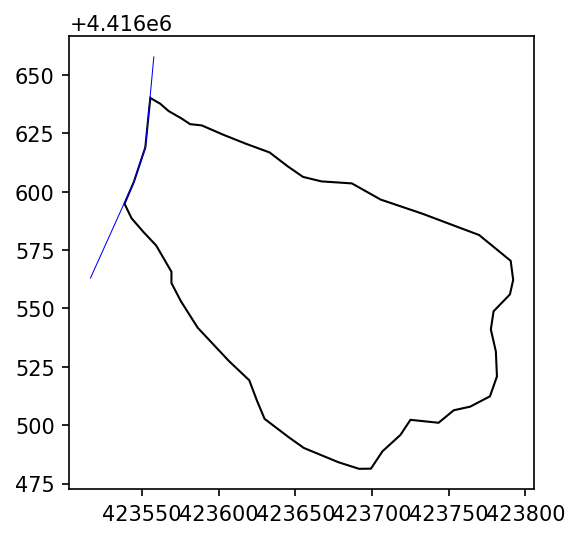

In [31]:
fig,ax = plt.subplots(1,1, figsize=(4,4))
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
# workflow.plot.rivers(reaches_s, crs, ax=ax, color='red', linewidth=1)
x,y = rivers_s[0].xy
ax.plot(x,y, 'b', linewidth = 0.5)

In [32]:
logging.info("Generate the river tree")
rivers = workflow.hydrography.make_global_tree(rivers_s)

2021-10-18 22:43:59,710 - root - INFO: Generate the river tree


In [29]:
# rivers = workflow.simplify_and_prune(watershed, rivers_s, filter=False, simplify=500, cut_intersections=True)

## Generate the surface mesh

First we'll generate the flattened, 2D triangulation, which builds on hydrography data.  Then we download a digital elevation map from the National Elevation Dataset, and extrude that 2D triangulation to a 3D surface mesh based on interpolation between pixels of the DEM.

Note: 
- use `tol` to adjust the tolerance of minmium distance between two nodes.
- The triangles at the intersection between river and watershed will be extremely small, use `mesh_rivers = False`.
- For quasi-uniform meshes, try setting `d1` greater than the watershed length, and the mesh size will be close to `A0`

2021-10-18 22:51:30,986 - root - INFO: 
2021-10-18 22:51:30,986 - root - INFO: Meshing
2021-10-18 22:51:30,987 - root - INFO: ------------------------------
2021-10-18 22:51:30,987 - root - INFO: Triangulating...
2021-10-18 22:51:30,988 - root - INFO:    51 points and 51 facets
2021-10-18 22:51:30,988 - root - INFO:  checking graph consistency
2021-10-18 22:51:30,989 - root - INFO:  tolerance is set to 1
2021-10-18 22:51:30,990 - root - INFO:  building graph data structures
2021-10-18 22:51:30,990 - root - INFO:  triangle.build...
2021-10-18 22:51:30,991 - root - WARNING: Triangulate: '--enforce-delaunay' option requires a hacked `meshpy.triangle`.  Proceeding without this option because it is not recognized.
2021-10-18 22:51:31,635 - root - INFO:   ...built: 1384 mesh points and 2629 triangles
2021-10-18 22:51:31,636 - root - INFO: Plotting triangulation diagnostics
2021-10-18 22:51:31,786 - root - INFO:   min area = 1.3050537109375
2021-10-18 22:51:31,786 - root - INFO:   max area = 

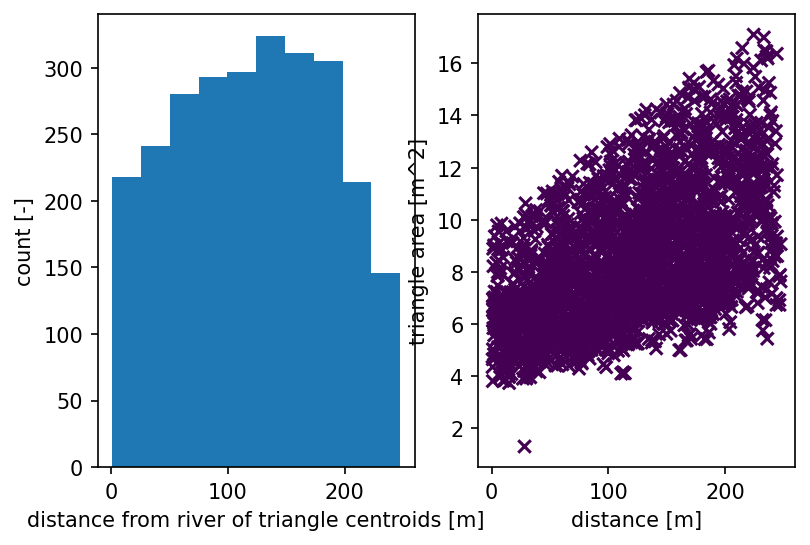

In [35]:
# form a triangulation on the shape + river network

# triangulation refinement:
# Refine triangles if their area (in m^2) is greater than A(d), where d is the 
# distance from the triangle centroid to the nearest stream.
# A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and
# linearly interpolates between the two endpoints.
d0 = 10; d1 = 300
A0 = 10; A1 = 20 # [10, 1000]m
# A0 = 10000; A1 = 500000 # [100, 1000]m
# A0 = 100000; A1 = 5000000

# Refine triangles if they get too acute
min_angle = 32 # degrees

# make 2D mesh
mesh_points2, mesh_tris, areas, distances = workflow.triangulate(watershed, rivers,
                                               refine_distance=[d0,A0,d1,A1],
                                               refine_min_angle=min_angle,
                                               enforce_delaunay=True,
                                               diagnostics=True)
#mesh_points2, mesh_tris, d = workflow.triangulate(watershed, rivers,
#                                                 refine_max_area=100000,
#                                                 enforce_delaunay=True,
#                                                 diagnostics=True)

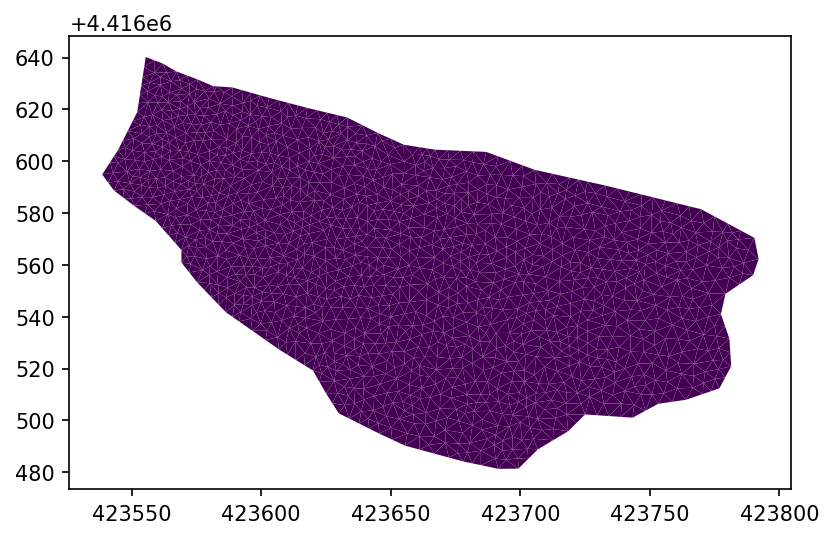

In [36]:
fig, ax = plt.subplots(1,1, figsize=(8, 4))
ax.set_aspect('equal')
ax.tripcolor(mesh_points2[:,0], mesh_points2[:,1], mesh_tris, facecolors= np.array([0]*len(mesh_tris)), 
                   cmap = None, edgecolors = 'w', linewidth=0.01)

## Import DEM

### Option 1--Bring your own DEM

In [38]:
logging.info("import dem from {}".format(fname_dem))
with rasterio.open(fname_dem, 'r') as fid:
    dem_profile = fid.profile
    dem = fid.read(1) # read the first band

2021-10-18 22:57:43,023 - root - INFO: import dem from /Users/shua784/OneDrive - PNNL/Projects/Fraser_hillslope/data/GIS/DEM/SecondGrowth.tif


### Option 2--Download DEM data from source

This download DEM from USGS NED with resolution of 1as (30 m).

In [99]:
# # get a raster for the elevation map
# dem_profile, dem = workflow.get_raster_on_shape(sources['DEM'], watershed.exterior(), crs)

Smooth DEM if DEM-res is larger than average mesh-res, and there is artifical pits.

Text(0.5, 1.0, 'smoothed')

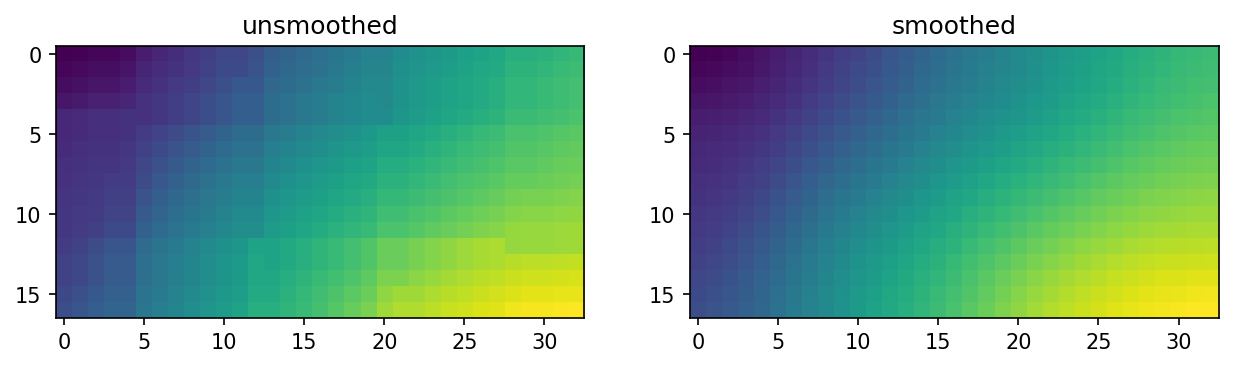

In [73]:
# noting that the DEM is a 30m raster, and we want to run at a coarser resolution of ~100-300m, 
# the DEM will look quite rough.  Smooth a small amount.  Note better algorithms could be used 
# here, but for now we just use Gaussian smoothing.
dem_sm = scipy.ndimage.gaussian_filter(dem, 2, mode='nearest')

fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(dem)
axs[0].set_title('unsmoothed')

axs[1].imshow(dem_sm)
axs[1].set_title('smoothed')


In [74]:
np.min(dem), np.max(dem)

(2817.3315, 2887.5305)

In [75]:
np.min(dem_sm), np.max(dem_sm)

(2818.8926, 2885.4888)

## elevate mesh to DEM

In [76]:
# elevate the triangle nodes to the dem
mesh_points3 = workflow.elevate(mesh_points2, crs, dem_sm, dem_profile, algorithm='piecewise bilinear')

2021-10-18 23:21:45,368 - root - INFO: 
2021-10-18 23:21:45,368 - root - INFO: Elevating Triangulation to DEM
2021-10-18 23:21:45,369 - root - INFO: ------------------------------


### plot surface mesh

Plotting the resulting mesh can be done in a variety of ways, including both 3D plots and mapview.  We show both here, but hereafter use mapview plots as they are a bit clearer (if not so flashy)...

[Text(4416460.0, 0, ''),
 Text(4416480.0, 0, ''),
 Text(4416500.0, 0, ''),
 Text(4416520.0, 0, ''),
 Text(4416540.0, 0, ''),
 Text(4416560.0, 0, ''),
 Text(4416580.0, 0, ''),
 Text(4416600.0, 0, ''),
 Text(4416620.0, 0, ''),
 Text(4416640.0, 0, ''),
 Text(4416660.0, 0, '')]

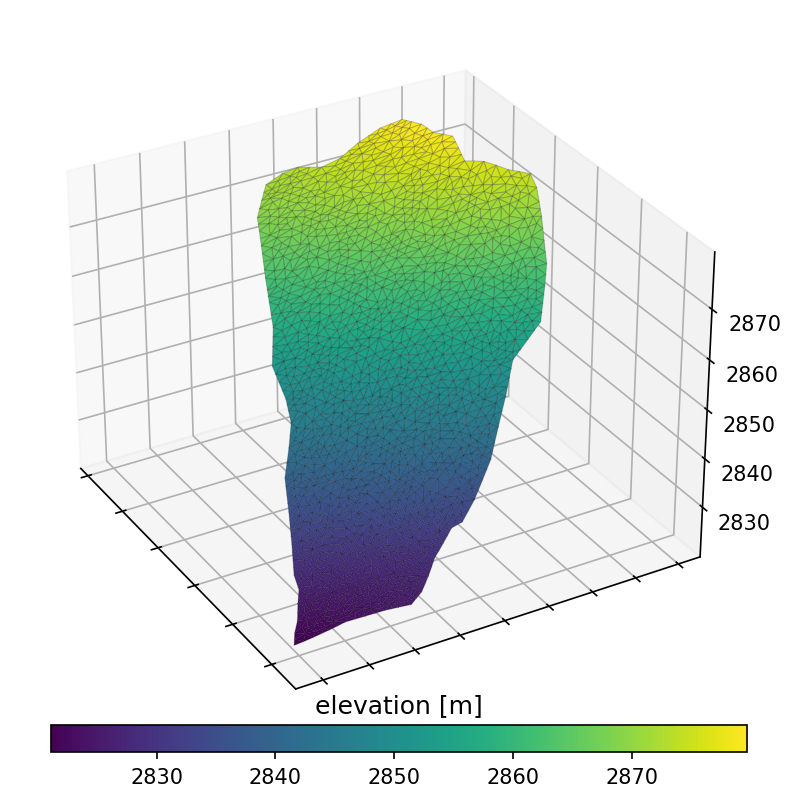

In [77]:
figsize = (6,6)
figsize_3d = (8,6)

# plot the resulting surface mesh
fig = plt.figure(figsize=figsize_3d)
ax = workflow.plot.get_ax('3d', fig, window=[0.0,0.2,1,0.8])
cax = fig.add_axes([0.23,0.18,0.58,0.03])

mp = ax.plot_trisurf(mesh_points3[:,0], mesh_points3[:,1], mesh_points3[:,2], 
                     triangles=mesh_tris, cmap='viridis', 
                     edgecolor=(0,0,0,.2), linewidth=0.5)
cb = fig.colorbar(mp, orientation="horizontal", cax=cax)

t = cax.set_title('elevation [m]')
ax.view_init(30,150)
ax.set_xticklabels(list())
ax.set_yticklabels(list())

#fig.savefig('watershed_dem_3d')

Text(0.5, 1.0, 'elevation [m]')

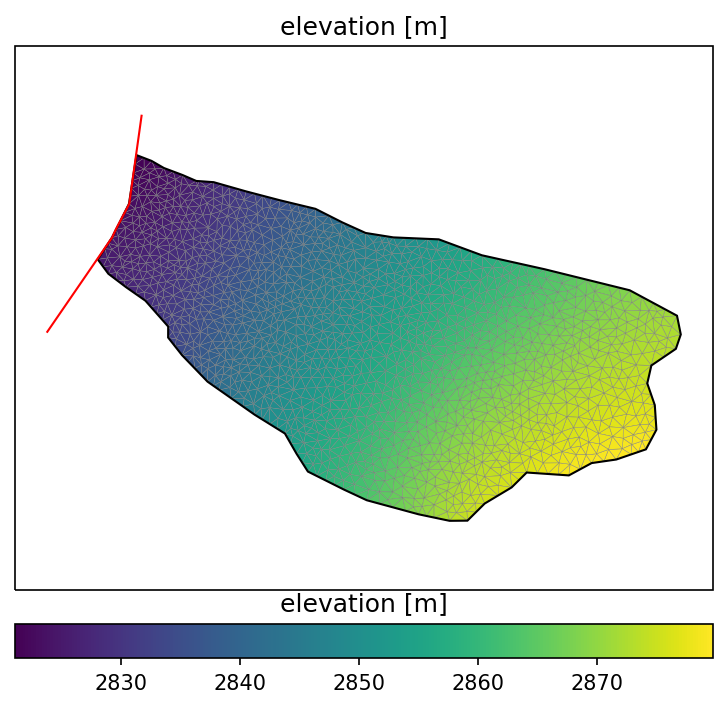

In [78]:
# plot the resulting surface mesh
fig = plt.figure(figsize=figsize)
ax = workflow.plot.get_ax(crs, fig)

mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, 
                                 color='elevation', edgecolor='gray', linewidth=0.2)
cbar = fig.colorbar(mp, orientation="horizontal", pad=0.05)
workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax, color='red', linewidth=1)
ax.set_aspect('equal', 'datalim')
ax.set_title('elevation [m]')
cbar.ax.set_title('elevation [m]')
#fig.savefig('coweeta_dem')

### construct 2D mesh

In [79]:
m2 = workflow.mesh.Mesh2D(coords = mesh_points3.copy(), conn = list(mesh_tris))

### hydrologically conditioning the mesh in place by removing pits (optional)

max diff =  0.27700315769970985


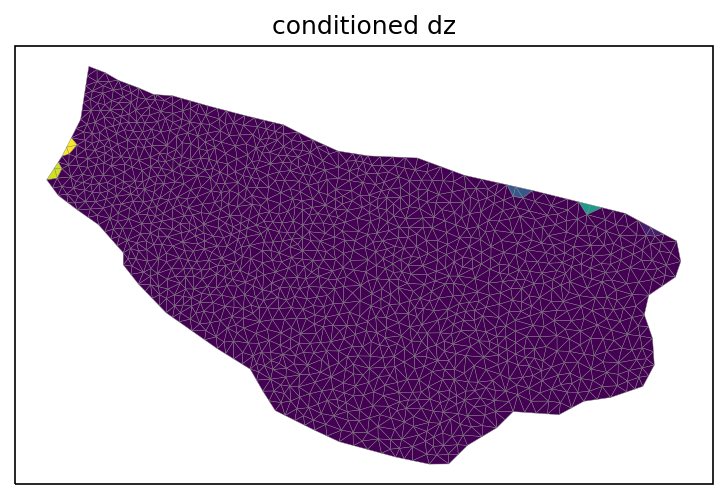

In [80]:
# workflow.condition.condition(m2)

# hydrologically condition the mesh, removing pits
workflow.condition.fill_pits_dual(m2)

# plot the change between the two meshes
diff = np.copy(mesh_points3)
diff[:,2] = m2.coords[:,2] - mesh_points3[:,2] 
print("max diff = ", np.abs(diff[:,2]).max())
fig, ax = workflow.plot.get_ax(crs, figsize=figsize)
workflow.plot.triangulation(diff, m2.conn, crs, color='elevation', edgecolors='gray', 
                            linewidth=0.2, ax=ax)
ax.set_title('conditioned dz')
plt.show()

### export surface mesh to VTK

In [81]:
m2.write_VTK(fname_surface_mesh)

## Mesh extrusion

Given the surface mesh and material IDs on both the surface and subsurface, we can extrude the surface mesh in the vertical to make a 3D mesh.

In [82]:
ele_per_layer = mesh_tris.shape[0]
ele_per_layer

2629

In [83]:
# shallow 0-1.2 m: loamy sand; deep 1.2~ 4 m: sandy loam
tckness = [0.6, 0.6, 0.7, 0.7, 0.7, 0.7]

In [ ]:
# dz=0.5
# tele = 1.1 # increment factor
# tckness = [np.around(dz*tele**(i), decimals=2) for i in np.arange(17)]
# # + np.repeat(5, 1, axis=0).tolist()
# sum(tckness)

In [85]:
mat_ids = [1, 1, 2, 2, 2, 2]

In [84]:
# mat_ids = np.arange(1, len(tckness)+1) # layer ids

In [86]:
layer_types = ['constant'] * len(tckness)
layer_data = tckness
layer_ncells = [1] * len(tckness)
layer_mat_ids = [np.array([i]*ele_per_layer, dtype=int) for i in mat_ids]

In [87]:
logging.info(f"No of cells: {len(layer_data)*ele_per_layer}")

2021-10-18 23:26:42,998 - root - INFO: No of cells: 15774


In [41]:
# layer extrusion
# -- data structures needed for extrusion
# layer_types = []
# layer_data = []
# layer_ncells = []
# layer_mat_ids = []
# z = 0.0

# # -- soil layer --
# #  top 6 m
# #  5 cm initial top cell
# #  10 cells
# #  expanding dz, growing with depth
# ncells = 9 # num of layers
# dz = 0.1 # top layer thickness
# layer_dz = 4 # thickness of total soil layer

# # get increment factor between 1x and 2x to fill a given layer. i.e.,  
# # find f so that z0 + z0*f + z0*f^2 + z0*f^3 + ... + z0*f^ncell <= layer_dz
# tele = workflow.mesh.telescope_factor(ncells, dz, layer_dz)
# logging.info("Got telescoping factor: {}".format(tele))

# for i in range(ncells):
#     layer_types.append('constant')
#     layer_data.append(dz)
#     layer_ncells.append(1)
#     layer_mat_ids.append(soil_color)
#     z += dz
#     dz *= tele
       
# # one more 2m layer makes 6m
# dz = 2.0
# layer_types.append('constant')
# layer_data.append(dz)
# layer_ncells.append(1)
# layer_mat_ids.append(soil_color)
# z += dz

# # -- geologic layer --
# # keep going for 2m cells until we hit the bottom of
# # the domain
# layer_types.append("constant")
# layer_data.append(40 - z) # depth of bottom of domain is 40 m
# layer_ncells.append(int(round(layer_data[-1] / dz)))
# layer_mat_ids.append(999*np.ones_like(soil_color))

In [88]:
# print the summary
workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

2021-10-18 23:26:50,491 - root - INFO: Cell summary:
2021-10-18 23:26:50,492 - root - INFO: ------------------------------------------------------------
2021-10-18 23:26:50,492 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2021-10-18 23:26:50,492 - root - INFO: ------------------------------------------------------------
2021-10-18 23:26:50,493 - root - INFO:  00 	| 00 	|    1 	|   0.600000 	|   0.000000
2021-10-18 23:26:50,494 - root - INFO:  01 	| 01 	|    1 	|   0.600000 	|   0.600000
2021-10-18 23:26:50,494 - root - INFO:  02 	| 02 	|    2 	|   0.700000 	|   1.200000
2021-10-18 23:26:50,494 - root - INFO:  03 	| 03 	|    2 	|   0.700000 	|   1.900000
2021-10-18 23:26:50,495 - root - INFO:  04 	| 04 	|    2 	|   0.700000 	|   2.600000
2021-10-18 23:26:50,495 - root - INFO:  05 	| 05 	|    2 	|   0.700000 	|   3.300000


In [89]:
# extrude
m3 = workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

### add land cover sidesets (optional)

In [43]:
# # add back on land cover side sets
# surf_ss = m3.side_sets[1]

# for index, name in zip(nlcd_indices, nlcd_labels):
#     where = np.where(lc == index)[0]
#     ss = workflow.mesh.SideSet(name, int(index), 
#                             [surf_ss.elem_list[w] for w in where],
#                             [surf_ss.side_list[w] for w in where])        
#     m3.side_sets.append(ss)

## export mesh file

In [90]:
# save to disk
try:
    os.remove(fname_final_mesh)
except FileNotFoundError:
    pass
m3.write_exodus(fname_final_mesh)


You are using exodus.py v 1.19.1 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013, 2014, 2015, 2016, 2017, 2018, 2019 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: ./meshes/SecondGrowth_mesh-10m.exo
Closing exodus file: ./meshes/SecondGrowth_mesh-10m.exo
